# Imports

In [1]:
# imports and connect to google drive
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
import scipy.io as spio
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pylab import figure, cm
import numpy as np
from scipy.ndimage import zoom
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from scipy.io import savemat

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# global variables used below
# 42 and 4323 were chose at random
randIndex = 42
imageIndex = 4232
epochs = 10

# Upsampling Ratio of 3

## Load Data and Build Upscaled Noisely Dataset

In [6]:
# Load MATLAB matrices
mat_images = spio.loadmat("/content/drive/MyDrive/ENGS117/Copy of STL10Images.mat")
mat_low_res_images = spio.loadmat("/content/drive/MyDrive/ENGS117/Copy of LowResSTL10Images.mat")

# Access the matrices inside the dictionaries
imageData = mat_images['imageData'] / 255.0
lowResImageData = mat_low_res_images['lowResImageData'] / 255.0

# Print the shapes
print("Shape of imageData:", imageData.shape)
print("Shape of lowResImageData:", lowResImageData.shape)

Shape of imageData: (20000, 96, 96)
Shape of lowResImageData: (20000, 32, 32)


In [4]:
num_images = lowResImageData.shape[0]
scaling_factor = 3
upscaledImages = np.zeros((num_images, 96, 96))
print("Shape of upscaledImages:", upscaledImages.shape)
# Loop through each image and upscale
for i in range(num_images):
  low_res_image = lowResImageData[i, :, :]
  upscaledImage = zoom(low_res_image, scaling_factor, order=3)
  upscaledImages[i, :, :] = upscaledImage

# save the upscaled matrix in drive (this is done constantly in the code here for all upscaled
# numpy matrices as I was running into issues with system RAM and wanted to save all RAM for the
# deep learning part)
np.save("/content/drive/MyDrive/ENGS117/upscaled_images.npy", upscaledImages)

Shape of upscaledImages: (20000, 96, 96)


In [4]:
# To load the saved upscaledImages
upscaledImages = np.load("/content/drive/MyDrive/ENGS117/upscaled_images.npy")

### Plot Images

SNR: 5.508803580874658
4232


Text(0.5, 1.0, 'Low Res Upscaled Image')

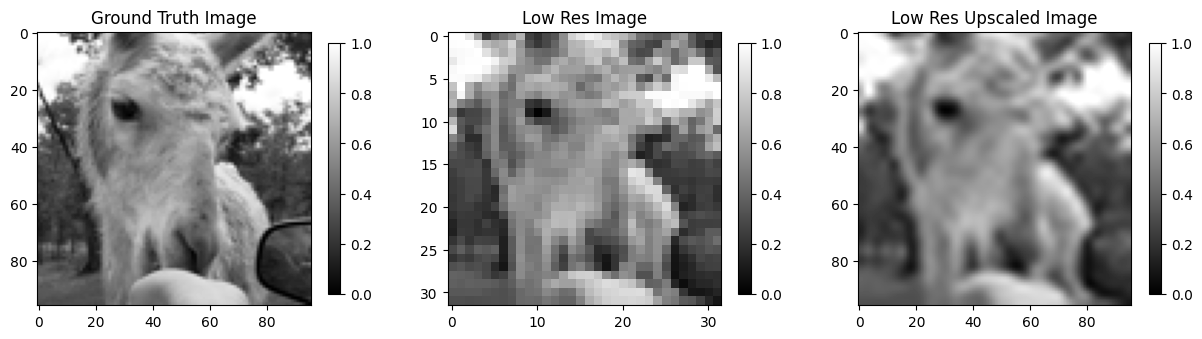

In [5]:
# Calculate SNR just to see how different upscaled version is from ground truth
signal = np.mean(imageData)
noise = np.std(upscaledImages - imageData)
snr = signal / noise
print(f"SNR: {snr}")

print(imageIndex)

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(imageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res image
plt.subplot(1, 3, 2)
im2 = plt.imshow(lowResImageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 3)
im3 = plt.imshow(upscaledImages[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Low Res Upscaled Image')

### Spilt into training, testing, and validation sets

In [5]:
# split into training and testing and validation sets (80/10/10)
X_train, X_temp, Y_train, Y_temp = train_test_split(upscaledImages, imageData, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


### Build U-net architecture

In [3]:
def srcnn_unet(input_shape):
    inputs = keras.layers.Input(input_shape)

    # Encoder
    conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

     # Bottleneck
    conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)

    # Decoder
    up_conv5 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv4)
    merge5 = keras.layers.concatenate([conv3, up_conv5], axis=3)
    conv5 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge5)

    up_conv6 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv5)
    merge6 = keras.layers.concatenate([conv2, up_conv6], axis=3)
    conv6 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge6)

    up_conv7 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu', padding='same')(conv6)
    merge7 = keras.layers.concatenate([conv1, up_conv7], axis=3)
    conv7 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge7)

    outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    return keras.models.Model(inputs, outputs)


### Build model for noiseless super resolution

In [7]:
# Prepare data and create the model
input_shape = (96, 96, 1)
model = srcnn_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model with early stopping
for epoch in range(epochs):
    model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, Y_test)
    print(f"Epoch {epoch + 1} - Test MSE: {test_loss}")

    # Check if the validation loss has stopped decreasing
    if early_stopping.stopped_epoch > 0:
        print("Validation loss has plateaued. Stopping training.")
        break

63/63 [==============================] - 1s 14ms/step - loss: 0.0041
Epoch 1 - Test MSE: 0.004114712122827768
63/63 [==============================] - 1s 15ms/step - loss: 0.0038
Epoch 2 - Test MSE: 0.003774416632950306
63/63 [==============================] - 1s 15ms/step - loss: 0.0037
Epoch 3 - Test MSE: 0.0037486946675926447
63/63 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 4 - Test MSE: 0.003573332680389285
63/63 [==============================] - 1s 15ms/step - loss: 0.0035
Epoch 5 - Test MSE: 0.003496275981888175
63/63 [==============================] - 1s 14ms/step - loss: 0.0034
Epoch 6 - Test MSE: 0.00343162938952446
63/63 [==============================] - 1s 14ms/step - loss: 0.0034
Epoch 7 - Test MSE: 0.00339691829867661
63/63 [==============================] - 1s 15ms/step - loss: 0.0034
Epoch 8 - Test MSE: 0.0033630398102104664
63/63 [==============================] - 1s 15ms/step - loss: 0.0034
Epoch 9 - Test MSE: 0.003357954090461135
63/63 [===

### Plot

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'Predicted Image')

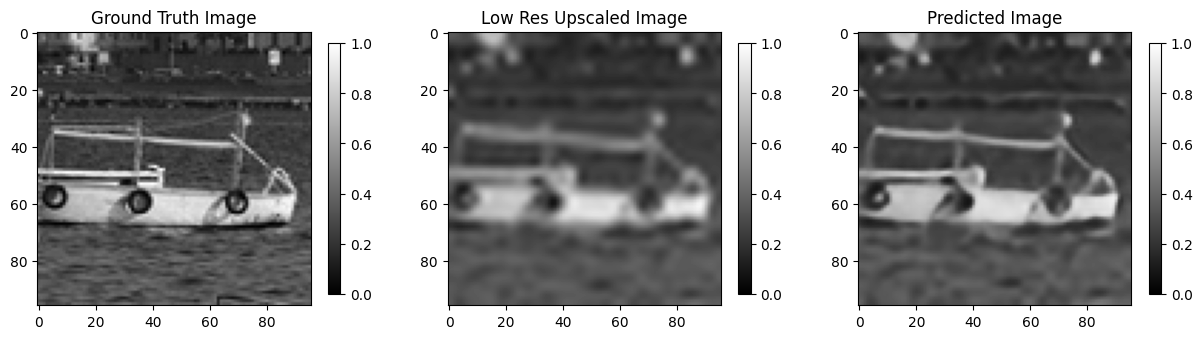

In [25]:
# compare with random true image from X_test which contains 2000s images (index defined above)
predictedImage = model.predict(X_test[randIndex:randIndex+1])

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(Y_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 2)
im2 = plt.imshow(X_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Upscaled Image')

# plot the output of image using our model
plt.subplot(1, 3, 3)
im3 = plt.imshow(predictedImage[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Predicted Image')


## Reconstruction with noise (SNR = 2.36)

In [ ]:
target_snr = 2.0

# Calculate the noise level based on SNR
noise_level = np.std(imageData) / (10 ** (target_snr / 20.0))

# Generate noise with the calculated noise level
noise = np.random.normal(loc=0, scale=noise_level, size=lowResImageData.shape)

# Add noise to the original images
noisyLowResImageData = lowResImageData + noise

# Clip values to ensure they are between 0 and 1
noisyLowResImageData = np.clip(noisyLowResImageData, 0, 1)


upscaledNoisyImages = np.zeros((num_images, 96, 96))
# Loop through each image and upscale
for i in range(num_images):
  noisyLowResImage = noisyLowResImageData[i, :, :]
  upscaledNoisyImage = zoom(noisyLowResImage, scaling_factor, order=3)
  upscaledNoisyImages[i, :, :] = upscaledNoisyImage

# Calculate SNR (obviously will be different from target as added to low res version of ground truth image)
signal = np.mean(imageData)
noise = np.std(upscaledNoisyImages - imageData)
snr = signal / noise
print(f"Actual SNR: {snr}")


np.save("/content/drive/MyDrive/ENGS117/upscaled_images1.npy", upscaledNoisyImages)

Actual SNR: 2.3614907199390944


In [27]:
# To load the saved upscaledImages
upscaledNoisyImages = np.load("/content/drive/MyDrive/ENGS117/upscaled_images1.npy")

SNR: 2.3614907199390944


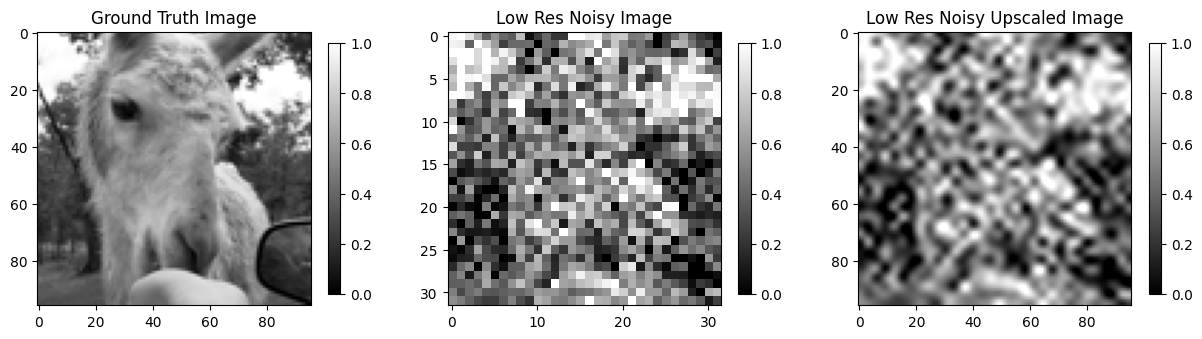

In [ ]:
plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(imageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res image
plt.subplot(1, 3, 2)
im2 = plt.imshow(noisyLowResImageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Noisy Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 3)
im3 = plt.imshow(upscaledNoisyImages[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Low Res Noisy Upscaled Image')

### Split into training, testing, and validaiton sets

In [28]:
# split into training and testing and validation sets (80/10/10)
X_train, X_temp, Y_train, Y_temp = train_test_split(upscaledNoisyImages, imageData, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


### Build model

In [29]:
# Prepare data and create the model
input_shape = (96, 96, 1)
model = srcnn_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
for epoch in range(epochs):
    model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, Y_test)
    print(f"Epoch {epoch + 1} - Test MSE: {test_loss}")

    # Check if the validation loss has stopped decreasing
    if early_stopping.stopped_epoch > 0:
        print("Validation loss has plateaued. Stopping training.")
        break

63/63 [==============================] - 1s 14ms/step - loss: 0.0088
Epoch 1 - Test MSE: 0.0088129173964262
63/63 [==============================] - 1s 14ms/step - loss: 0.0083
Epoch 2 - Test MSE: 0.008268753066658974
63/63 [==============================] - 1s 14ms/step - loss: 0.0082
Epoch 3 - Test MSE: 0.008165420033037663
63/63 [==============================] - 1s 14ms/step - loss: 0.0081
Epoch 4 - Test MSE: 0.008080882020294666
63/63 [==============================] - 1s 14ms/step - loss: 0.0080
Epoch 5 - Test MSE: 0.008041857741773129
63/63 [==============================] - 1s 14ms/step - loss: 0.0080
Epoch 6 - Test MSE: 0.008016609586775303
63/63 [==============================] - 1s 15ms/step - loss: 0.0081
Epoch 7 - Test MSE: 0.008055711165070534
63/63 [==============================] - 1s 14ms/step - loss: 0.0080
Epoch 8 - Test MSE: 0.008039886131882668
63/63 [==============================] - 1s 14ms/step - loss: 0.0080
Epoch 9 - Test MSE: 0.008036624640226364
63/63 [=====

### Plot

1/1 [==============================] - 0s 299ms/step


Text(0.5, 1.0, 'Predicted Image')

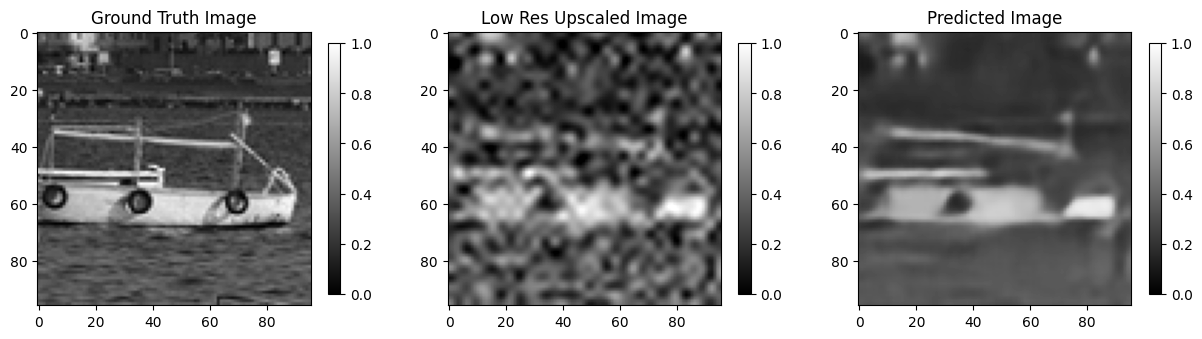

In [30]:
predictedImage = model.predict(X_test[randIndex:randIndex+1])

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(Y_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 2)
im2 = plt.imshow(X_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Upscaled Image')

# plot the output of image using our model
plt.subplot(1, 3, 3)
im3 = plt.imshow(predictedImage[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Predicted Image')


## Reconstruction with noise (SNR = 2.99)



In [12]:
target_snr = 5.0

# Calculate the noise level based on SNR
noise_level = np.std(imageData) / (10 ** (target_snr / 20.0))

# Generate noise with the calculated noise level
noise = np.random.normal(loc=0, scale=noise_level, size=lowResImageData.shape)

# Add noise to the original images
noisyLowResImageData = lowResImageData + noise

# Clip values to ensure they are between 0 and 1
noisyLowResImageData = np.clip(noisyLowResImageData, 0, 1)


upscaledNoisyImages = np.zeros((num_images, 96, 96))
# Loop through each image and upscale
for i in range(num_images):
  noisyLowResImage = noisyLowResImageData[i, :, :]
  upscaledNoisyImage = zoom(noisyLowResImage, scaling_factor, order=3)
  upscaledNoisyImages[i, :, :] = upscaledNoisyImage

# Calculate actual SNR when compared to ground truth
signal = np.mean(imageData)
noise = np.std(upscaledNoisyImages - imageData)
snr = signal / noise
print(f"Actual SNR: {snr}")


np.save("/content/drive/MyDrive/ENGS117/upscaled_images2.npy", upscaledNoisyImages)

Actual SNR: 2.9939732878722944


In [31]:
# To load the saved upscaledImages in another session or script
upscaledNoisyImages = np.load("/content/drive/MyDrive/ENGS117/upscaled_images2.npy")

SNR: 2.994127734782353


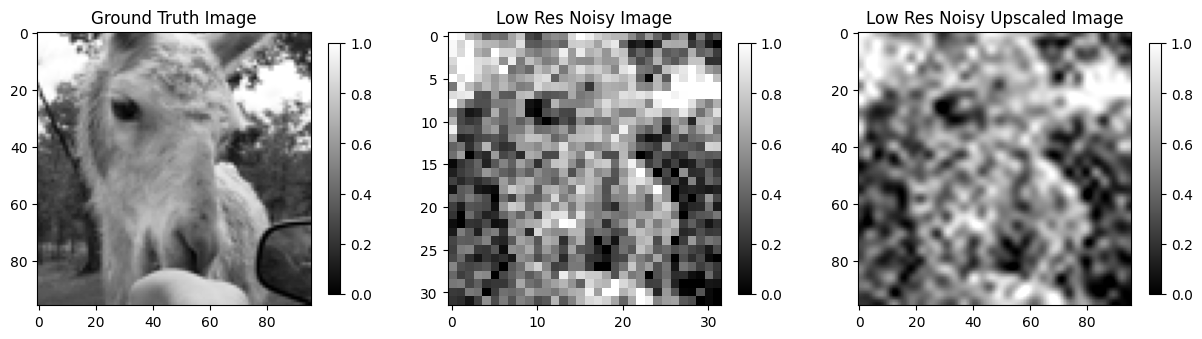

In [ ]:
plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(imageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res image
plt.subplot(1, 3, 2)
im2 = plt.imshow(noisyLowResImageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Noisy Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 3)
im3 = plt.imshow(upscaledNoisyImages[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Low Res Noisy Upscaled Image')

### Split into training, testing, and validaiton sets

In [32]:
# split into training and testing and validation sets (80/10/10)
X_train, X_temp, Y_train, Y_temp = train_test_split(upscaledNoisyImages, imageData, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


### Build model

In [33]:
# Prepare data and create the model
input_shape = (96, 96, 1)
model = srcnn_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model with early stopping
for epoch in range(epochs):
    model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, Y_test)
    print(f"Epoch {epoch + 1} - Test MSE: {test_loss}")

    # Check if the validation loss has stopped decreasing
    if early_stopping.stopped_epoch > 0:
        print("Validation loss has plateaued. Stopping training.")
        break

63/63 [==============================] - 1s 14ms/step - loss: 0.0080
Epoch 1 - Test MSE: 0.007979990914463997
63/63 [==============================] - 1s 14ms/step - loss: 0.0075
Epoch 2 - Test MSE: 0.007487426977604628
63/63 [==============================] - 1s 14ms/step - loss: 0.0073
Epoch 3 - Test MSE: 0.007349859457463026
63/63 [==============================] - 1s 14ms/step - loss: 0.0073
Epoch 4 - Test MSE: 0.007296619471162558
63/63 [==============================] - 1s 14ms/step - loss: 0.0073
Epoch 5 - Test MSE: 0.007324542384594679
63/63 [==============================] - 1s 14ms/step - loss: 0.0072
Epoch 6 - Test MSE: 0.00722363730892539
63/63 [==============================] - 1s 14ms/step - loss: 0.0073
Epoch 7 - Test MSE: 0.007255008909851313
63/63 [==============================] - 1s 15ms/step - loss: 0.0072
Epoch 8 - Test MSE: 0.0072205523028969765
63/63 [==============================] - 1s 14ms/step - loss: 0.0072
Epoch 9 - Test MSE: 0.007227085530757904
63/63 [===

### Plot

1/1 [==============================] - 0s 167ms/step


Text(0.5, 1.0, 'Predicted Image')

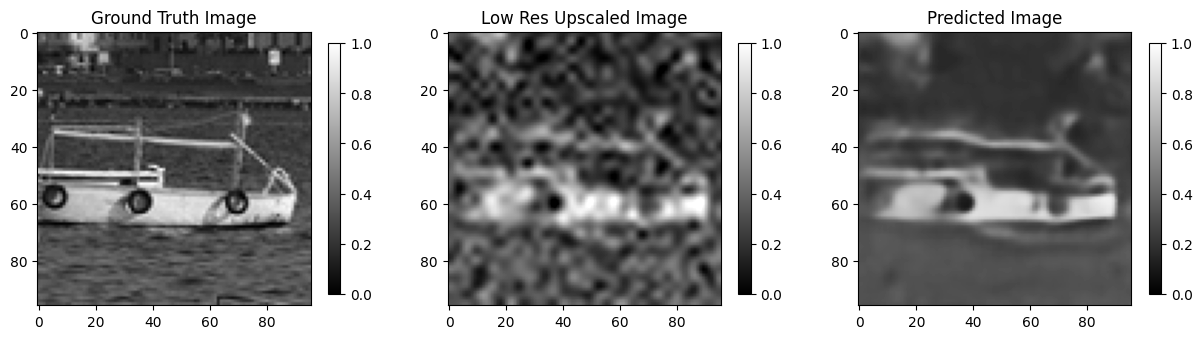

In [34]:
predictedImage = model.predict(X_test[randIndex:randIndex+1])

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(Y_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 2)
im2 = plt.imshow(X_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Upscaled Image')

# plot the output of image using our model
plt.subplot(1, 3, 3)
im3 = plt.imshow(predictedImage[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Predicted Image')


## Reconstruction with noise (SNR = 4.11)

In [ ]:
target_snr = 10.0

# Calculate the noise level based on SNR
noise_level = np.std(imageData) / (10 ** (target_snr / 20.0))

# Generate noise with the calculated noise level
noise = np.random.normal(loc=0, scale=noise_level, size=lowResImageData.shape)

# Add noise to the original images
noisyLowResImageData = lowResImageData + noise

# Clip values to ensure they are between 0 and 1
noisyLowResImageData = np.clip(noisyLowResImageData, 0, 1)


upscaledNoisyImages = np.zeros((num_images, 96, 96))
# Loop through each image and upscale
for i in range(num_images):
  noisyLowResImage = noisyLowResImageData[i, :, :]
  upscaledNoisyImage = zoom(noisyLowResImage, scaling_factor, order=3)
  upscaledNoisyImages[i, :, :] = upscaledNoisyImage

# Calculate the actual SNR
signal = np.mean(imageData)
noise = np.std(upscaledNoisyImages - imageData)
snr = signal / noise
print(f"Actual SNR: {snr}")

np.save("/content/drive/MyDrive/ENGS117/upscaled_images3.npy", upscaledNoisyImages)

Actual SNR: 4.111647698118683


In [4]:
# To load the saved upscaledImages
upscaledNoisyImages = np.load("/content/drive/MyDrive/ENGS117/upscaled_images3.npy")

SNR: 4.111647698118683


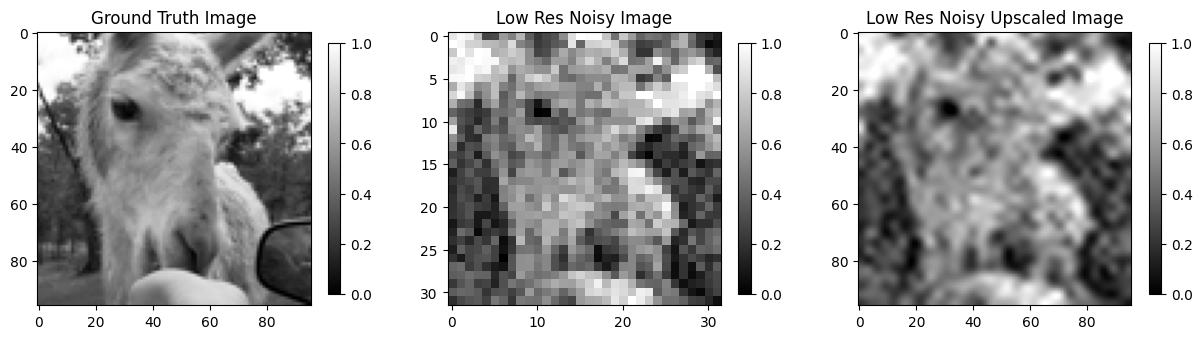

In [ ]:
plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(imageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res image
plt.subplot(1, 3, 2)
im2 = plt.imshow(noisyLowResImageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Noisy Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 3)
im3 = plt.imshow(upscaledNoisyImages[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Low Res Noisy Upscaled Image')

### Split into training, testing, and validaiton sets

In [5]:
# split into training and testing and validation sets (80/10/10)
X_train, X_temp, Y_train, Y_temp = train_test_split(upscaledNoisyImages, imageData, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


### Build model

In [8]:
# Prepare data and create the model
input_shape = (96, 96, 1)
model = srcnn_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model with early stopping
for epoch in range(epochs):
    model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, Y_test)
    print(f"Epoch {epoch + 1} - Test MSE: {test_loss}")

    # Check if the validation loss has stopped decreasing
    if early_stopping.stopped_epoch > 0:
        print("Validation loss has plateaued. Stopping training.")
        break

63/63 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 1 - Test MSE: 0.0043677291832864285
63/63 [==============================] - 1s 14ms/step - loss: 0.0039
Epoch 2 - Test MSE: 0.003904394805431366
63/63 [==============================] - 1s 15ms/step - loss: 0.0038
Epoch 3 - Test MSE: 0.0038054105825722218
63/63 [==============================] - 1s 14ms/step - loss: 0.0037
Epoch 4 - Test MSE: 0.0036957270931452513
63/63 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 5 - Test MSE: 0.003630660241469741
63/63 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 6 - Test MSE: 0.0035784966312348843
63/63 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 7 - Test MSE: 0.0035578571259975433
63/63 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 8 - Test MSE: 0.0036287596449255943
63/63 [==============================] - 1s 14ms/step - loss: 0.0035
Epoch 9 - Test MSE: 0.0035095042549073696
63/

### Plot

1/1 [==============================] - 0s 338ms/step


Text(0.5, 1.0, 'Predicted Image')

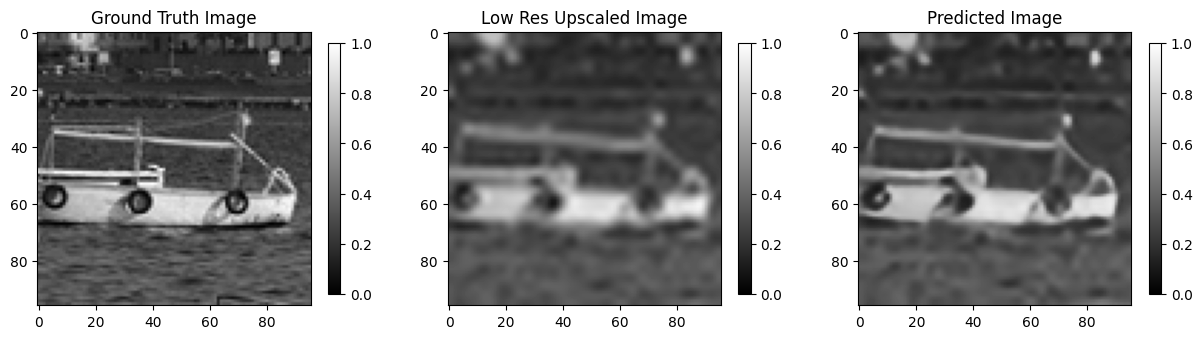

In [9]:
predictedImage = model.predict(X_test[randIndex:randIndex+1])

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(Y_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 2)
im2 = plt.imshow(X_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Upscaled Image')

# plot the output of image using our model
plt.subplot(1, 3, 3)
im3 = plt.imshow(predictedImage[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Predicted Image')


# Upsampling Ratio of 2

## Load Data and Build Upscaled Noisely Dataset

In [ ]:
# Load MATLAB matrix for low res image dataset
mat_low_res_images = spio.loadmat("/content/drive/MyDrive/ENGS117/Copy of LowRes2STL10Images.mat")

# Access the matrices inside the dictionaries
lowResImageData = mat_low_res_images['lowResImageData2'] / 255.0

# Print the shapes of ground truth and low res images
print("Shape of imageData:", imageData.shape)
print("Shape of lowResImageData:", lowResImageData.shape)

num_images = lowResImageData.shape[0]
scaling_factor = 2
upscaledImages = np.zeros((num_images, 96, 96))
print("Shape of upscaledImages:", upscaledImages.shape)
# Loop through each image and upscale
for i in range(num_images):
  low_res_image = lowResImageData[i, :, :]
  upscaledImage = zoom(low_res_image, scaling_factor, order=3)
  upscaledImages[i, :, :] = upscaledImage

np.save("/content/drive/MyDrive/ENGS117/upscaled_images4.npy", upscaledImages)

Shape of imageData: (20000, 96, 96)
Shape of lowResImageData: (20000, 48, 48)
Shape of upscaledImages: (20000, 96, 96)


In [5]:
# To load the saved upscaledImages
upscaledImages = np.load("/content/drive/MyDrive/ENGS117/upscaled_images4.npy")

### Plot Images

SNR: 7.6275857778086085
4232


Text(0.5, 1.0, 'Low Res Upscaled Image')

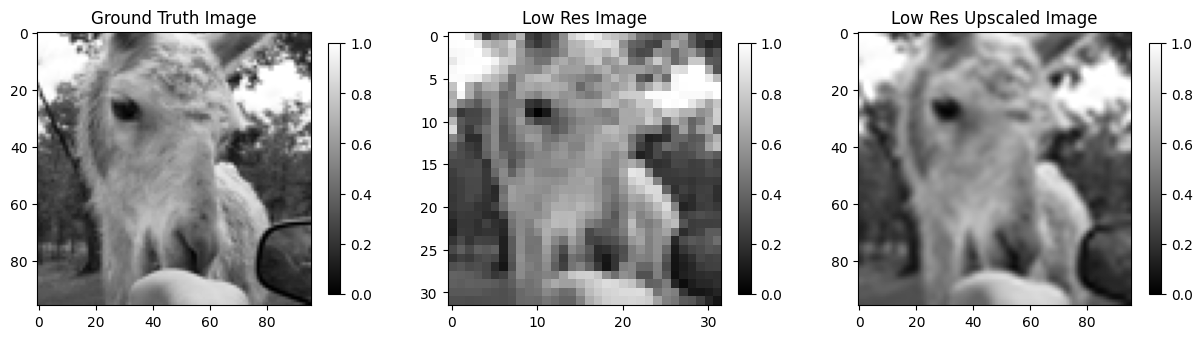

In [ ]:
# Calculate SNR
signal = np.mean(imageData)
noise = np.std(upscaledImages - imageData)
snr = signal / noise
print(f"SNR: {snr}")

print(imageIndex)

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(imageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res image
plt.subplot(1, 3, 2)
im2 = plt.imshow(lowResImageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 3)
im3 = plt.imshow(upscaledImages[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Low Res Upscaled Image')

### Spilt into training, testing, and validation sets

In [6]:
# split into training and testing and validation sets (80/10/10)
X_train, X_temp, Y_train, Y_temp = train_test_split(upscaledImages, imageData, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


### Build model for noiseless super resolution

In [7]:
# Prepare data and create the model
input_shape = (96, 96, 1)
model = srcnn_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model with early stopping
for epoch in range(epochs):
    model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, Y_test)
    print(f"Epoch {epoch + 1} - Test MSE: {test_loss}")

    # Check if the validation loss has stopped decreasing
    if early_stopping.stopped_epoch > 0:
        print("Validation loss has plateaued. Stopping training.")
        break

63/63 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 1 - Test MSE: 0.0020883267279714346
63/63 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 2 - Test MSE: 0.0018221221398562193
63/63 [==============================] - 1s 14ms/step - loss: 0.0017
Epoch 3 - Test MSE: 0.001744188484735787
63/63 [==============================] - 1s 14ms/step - loss: 0.0017
Epoch 4 - Test MSE: 0.0016747353365644813
63/63 [==============================] - 1s 14ms/step - loss: 0.0017
Epoch 5 - Test MSE: 0.001656029256992042
63/63 [==============================] - 1s 14ms/step - loss: 0.0016
Epoch 6 - Test MSE: 0.0016187282744795084
63/63 [==============================] - 1s 14ms/step - loss: 0.0016
Epoch 7 - Test MSE: 0.001604323973879218
63/63 [==============================] - 1s 14ms/step - loss: 0.0016
Epoch 8 - Test MSE: 0.0015954704722389579
63/63 [==============================] - 1s 14ms/step - loss: 0.0016
Epoch 9 - Test MSE: 0.0015831320779398084
63/6

### Plot

1/1 [==============================] - 0s 352ms/step


Text(0.5, 1.0, 'Predicted Image')

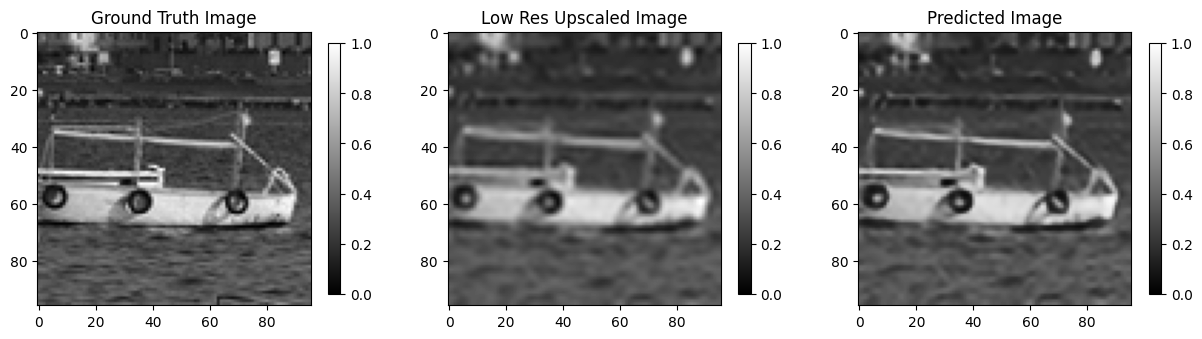

In [8]:
predictedImage = model.predict(X_test[randIndex:randIndex+1])

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(Y_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 2)
im2 = plt.imshow(X_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Upscaled Image')

# plot the output of image using our model
plt.subplot(1, 3, 3)
im3 = plt.imshow(predictedImage[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Predicted Image')


## Reconstruction with noise (SNR = 2.36)

In [ ]:
target_snr = 2.0

# Calculate the noise level based on SNR if just adding noise to ground truth
noise_level = np.std(imageData) / (10 ** (target_snr / 20.0))

# Generate noise with the calculated noise level
noise = np.random.normal(loc=0, scale=noise_level, size=lowResImageData.shape)

# Add noise to the original images
noisyLowResImageData = lowResImageData + noise

# Clip values to ensure they are between 0 and 1
noisyLowResImageData = np.clip(noisyLowResImageData, 0, 1)


upscaledNoisyImages = np.zeros((num_images, 96, 96))
# Loop through each image and upscale
for i in range(num_images):
  noisyLowResImage = noisyLowResImageData[i, :, :]
  upscaledNoisyImage = zoom(noisyLowResImage, scaling_factor, order=3)
  upscaledNoisyImages[i, :, :] = upscaledNoisyImage

# Calculate actual SNR
signal = np.mean(imageData)
noise = np.std(upscaledNoisyImages - imageData)
snr = signal / noise
print(f"Actual SNR: {snr}")


np.save("/content/drive/MyDrive/ENGS117/upscaled_images5.npy", upscaledNoisyImages)

Actual SNR: 2.3614996848095755


In [4]:
# To load the saved upscaledImages in another session or script
upscaledNoisyImages = np.load("/content/drive/MyDrive/ENGS117/upscaled_images5.npy")

Text(0.5, 1.0, 'Low Res Noisy Upscaled Image')

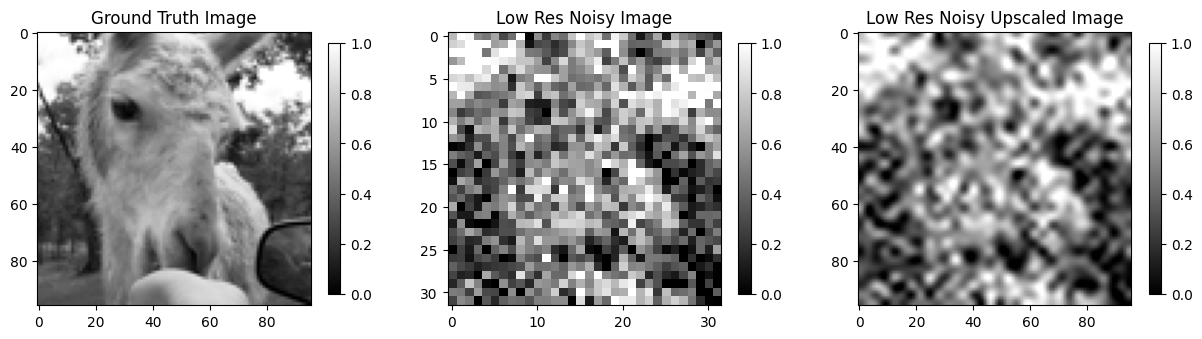

In [ ]:
plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(imageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res image
plt.subplot(1, 3, 2)
im2 = plt.imshow(noisyLowResImageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Noisy Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 3)
im3 = plt.imshow(upscaledNoisyImages[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Low Res Noisy Upscaled Image')

### Split into training, testing, and validaiton sets

In [7]:
# split into training and testing and validation sets (80/10/10)
X_train, X_temp, Y_train, Y_temp = train_test_split(upscaledNoisyImages, imageData, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


### Build model

In [8]:
# Prepare data and create the model
input_shape = (96, 96, 1)
model = srcnn_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model with early stopping
for epoch in range(epochs):
    model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, Y_test)
    print(f"Epoch {epoch + 1} - Test MSE: {test_loss}")

    # Check if the validation loss has stopped decreasing
    if early_stopping.stopped_epoch > 0:
        print("Validation loss has plateaued. Stopping training.")
        break

63/63 [==============================] - 1s 14ms/step - loss: 0.0054
Epoch 1 - Test MSE: 0.005354901775717735
63/63 [==============================] - 1s 14ms/step - loss: 0.0050
Epoch 2 - Test MSE: 0.004984661936759949
63/63 [==============================] - 1s 14ms/step - loss: 0.0049
Epoch 3 - Test MSE: 0.00486559234559536
63/63 [==============================] - 1s 14ms/step - loss: 0.0049
Epoch 4 - Test MSE: 0.004866487346589565
63/63 [==============================] - 1s 14ms/step - loss: 0.0048
Epoch 5 - Test MSE: 0.004756384529173374
63/63 [==============================] - 1s 14ms/step - loss: 0.0047
Epoch 6 - Test MSE: 0.004740171134471893
63/63 [==============================] - 1s 14ms/step - loss: 0.0047
Epoch 7 - Test MSE: 0.004708081018179655
63/63 [==============================] - 1s 14ms/step - loss: 0.0047
Epoch 8 - Test MSE: 0.004710131324827671
63/63 [==============================] - 1s 14ms/step - loss: 0.0047
Epoch 9 - Test MSE: 0.0047005051746964455
63/63 [===

### Plot

1/1 [==============================] - 0s 443ms/step


Text(0.5, 1.0, 'Predicted Image')

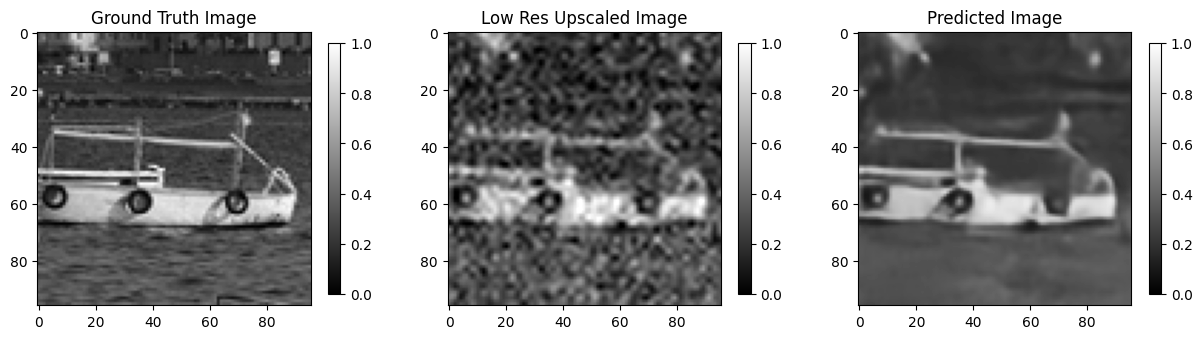

In [9]:
predictedImage = model.predict(X_test[randIndex:randIndex+1])

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(Y_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 2)
im2 = plt.imshow(X_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Upscaled Image')

# plot the output of image using our model
plt.subplot(1, 3, 3)
im3 = plt.imshow(predictedImage[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Predicted Image')


## Reconstruction with noise (SNR = 2.99)



In [ ]:
target_snr = 5.0

# Calculate the noise level based on SNR
noise_level = np.std(imageData) / (10 ** (target_snr / 20.0))

# Generate noise with the calculated noise level
noise = np.random.normal(loc=0, scale=noise_level, size=lowResImageData.shape)

# Add noise to the original images
noisyLowResImageData = lowResImageData + noise

# Clip values to ensure they are between 0 and 1
noisyLowResImageData = np.clip(noisyLowResImageData, 0, 1)


upscaledNoisyImages = np.zeros((num_images, 96, 96))
# Loop through each image and upscale
for i in range(num_images):
  noisyLowResImage = noisyLowResImageData[i, :, :]
  upscaledNoisyImage = zoom(noisyLowResImage, scaling_factor, order=3)
  upscaledNoisyImages[i, :, :] = upscaledNoisyImage

# Calculate SNR
signal = np.mean(imageData)
noise = np.std(upscaledNoisyImages - imageData)
snr = signal / noise
print(f"Actual SNR: {snr}")

np.save("/content/drive/MyDrive/ENGS117/upscaled_images6.npy", upscaledNoisyImages)

Actual SNR: 2.9947271301361265


In [10]:
upscaledNoisyImages = np.load("/content/drive/MyDrive/ENGS117/upscaled_images6.npy")

Text(0.5, 1.0, 'Low Res Noisy Upscaled Image')

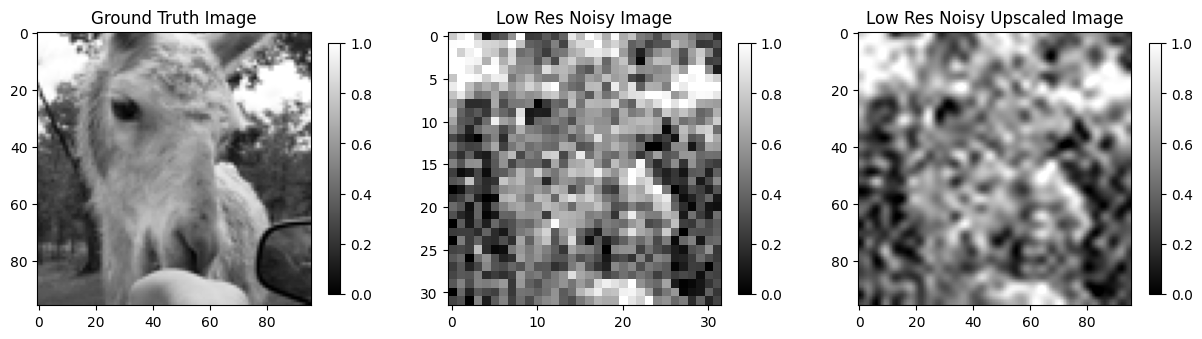

In [ ]:
plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(imageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res image
plt.subplot(1, 3, 2)
im2 = plt.imshow(noisyLowResImageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Noisy Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 3)
im3 = plt.imshow(upscaledNoisyImages[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Low Res Noisy Upscaled Image')

### Split into training, testing, and validaiton sets

In [11]:
# split into training and testing and validation sets (80/10/10)
X_train, X_temp, Y_train, Y_temp = train_test_split(upscaledNoisyImages, imageData, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


### Build model

In [12]:
# Prepare data and create the model
input_shape = (96, 96, 1)
model = srcnn_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model with early stopping
for epoch in range(epochs):
    model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, Y_test)
    print(f"Epoch {epoch + 1} - Test MSE: {test_loss}")

    # Check if the validation loss has stopped decreasing
    if early_stopping.stopped_epoch > 0:
        print("Validation loss has plateaued. Stopping training.")
        break

63/63 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 1 - Test MSE: 0.0027255055028945208
63/63 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 2 - Test MSE: 0.0025432005058974028
63/63 [==============================] - 1s 15ms/step - loss: 0.0026
Epoch 3 - Test MSE: 0.002565494505688548
63/63 [==============================] - 1s 15ms/step - loss: 0.0024
Epoch 4 - Test MSE: 0.0024499017745256424
63/63 [==============================] - 1s 14ms/step - loss: 0.0024
Epoch 5 - Test MSE: 0.0023771070409566164
63/63 [==============================] - 1s 14ms/step - loss: 0.0024
Epoch 6 - Test MSE: 0.0023650159128010273
63/63 [==============================] - 1s 14ms/step - loss: 0.0023
Epoch 7 - Test MSE: 0.0023416420444846153
63/63 [==============================] - 1s 14ms/step - loss: 0.0023
Epoch 8 - Test MSE: 0.002338106045499444
63/63 [==============================] - 1s 14ms/step - loss: 0.0023
Epoch 9 - Test MSE: 0.0023219657596200705
63/

### Plot

1/1 [==============================] - 0s 20ms/step


Text(0.5, 1.0, 'Predicted Image')

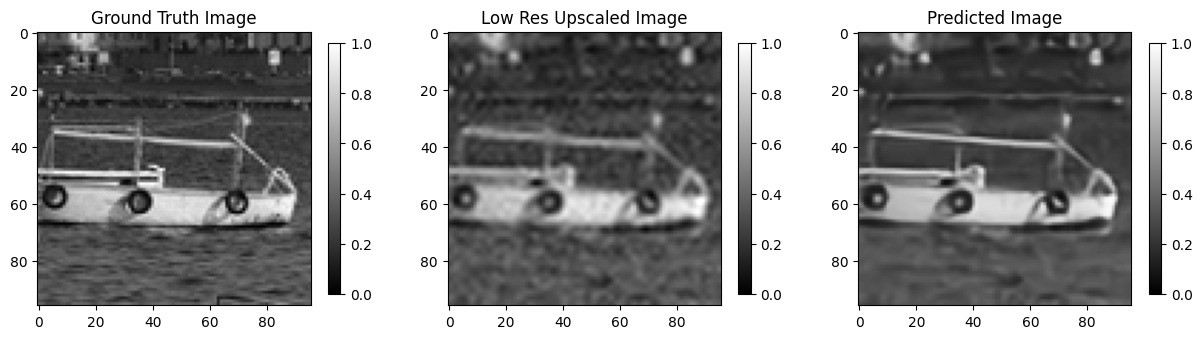

In [14]:
predictedImage = model.predict(X_test[randIndex:randIndex+1])

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(Y_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 2)
im2 = plt.imshow(X_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Upscaled Image')

# plot the output of image using our model
plt.subplot(1, 3, 3)
im3 = plt.imshow(predictedImage[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Predicted Image')


## Reconstruction with noise (SNR = 4.11)

In [ ]:
target_snr = 10.0

# Calculate the noise level based on SNR from the ground truth image
noise_level = np.std(imageData) / (10 ** (target_snr / 20.0))

# Generate noise with the calculated noise level
noise = np.random.normal(loc=0, scale=noise_level, size=lowResImageData.shape)

# Add noise to the original images
noisyLowResImageData = lowResImageData + noise

# Clip values to ensure they are between 0 and 1
noisyLowResImageData = np.clip(noisyLowResImageData, 0, 1)


upscaledNoisyImages = np.zeros((num_images, 96, 96))
# Loop through each image and upscale
for i in range(num_images):
  noisyLowResImage = noisyLowResImageData[i, :, :]
  upscaledNoisyImage = zoom(noisyLowResImage, scaling_factor, order=3)
  upscaledNoisyImages[i, :, :] = upscaledNoisyImage

# Calculate actual SNR
signal = np.mean(imageData)
noise = np.std(upscaledNoisyImages - imageData)
snr = signal / noise
print(f"Actual SNR: {snr}")

np.save("/content/drive/MyDrive/ENGS117/upscaled_images7.npy", upscaledNoisyImages)

Actual SNR: 4.112017555964862


In [15]:
# load the saved upscaledImages
upscaledNoisyImages = np.load("/content/drive/MyDrive/ENGS117/upscaled_images7.npy")

Text(0.5, 1.0, 'Low Res Noisy Upscaled Image')

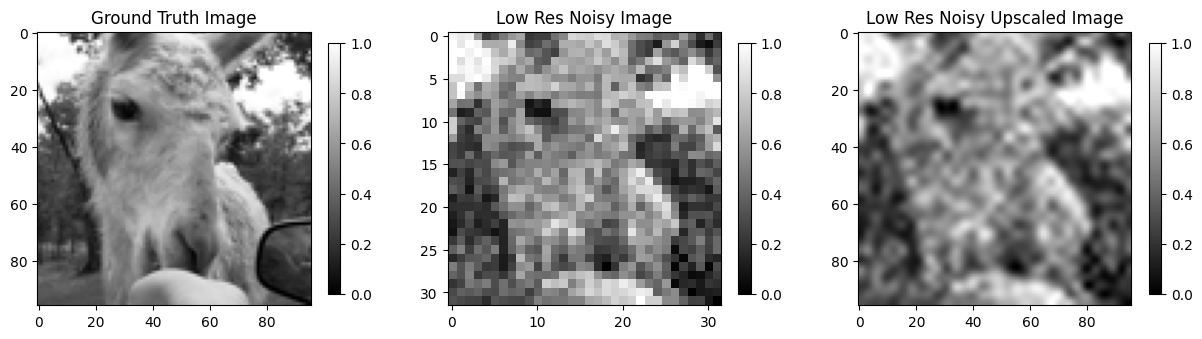

In [ ]:
plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(imageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res image
plt.subplot(1, 3, 2)
im2 = plt.imshow(noisyLowResImageData[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Noisy Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 3)
im3 = plt.imshow(upscaledNoisyImages[imageIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Low Res Noisy Upscaled Image')

### Split into training, testing, and validaiton sets

In [16]:
# split into training and testing and validation sets (80/10/10)
X_train, X_temp, Y_train, Y_temp = train_test_split(upscaledNoisyImages, imageData, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


### Build model

In [17]:
# Prepare data and create the model
input_shape = (96, 96, 1)
model = srcnn_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model with early stopping
for epoch in range(epochs):
    model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), callbacks=[early_stopping])

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, Y_test)
    print(f"Epoch {epoch + 1} - Test MSE: {test_loss}")

    # Check if the validation loss has stopped decreasing
    if early_stopping.stopped_epoch > 0:
        print("Validation loss has plateaued. Stopping training.")
        break

63/63 [==============================] - 1s 14ms/step - loss: 0.0023
Epoch 1 - Test MSE: 0.0022978470660746098
63/63 [==============================] - 1s 14ms/step - loss: 0.0020
Epoch 2 - Test MSE: 0.001958266133442521
63/63 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 3 - Test MSE: 0.0018610681872814894
63/63 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 4 - Test MSE: 0.0018983808113262057
63/63 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 5 - Test MSE: 0.0017964346334338188
63/63 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 6 - Test MSE: 0.0017995975213125348
63/63 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 7 - Test MSE: 0.001756949000991881
63/63 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 8 - Test MSE: 0.0017672849353402853
63/63 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 9 - Test MSE: 0.0017781651113182306
63/

### Plot

1/1 [==============================] - 0s 183ms/step


Text(0.5, 1.0, 'Predicted Image')

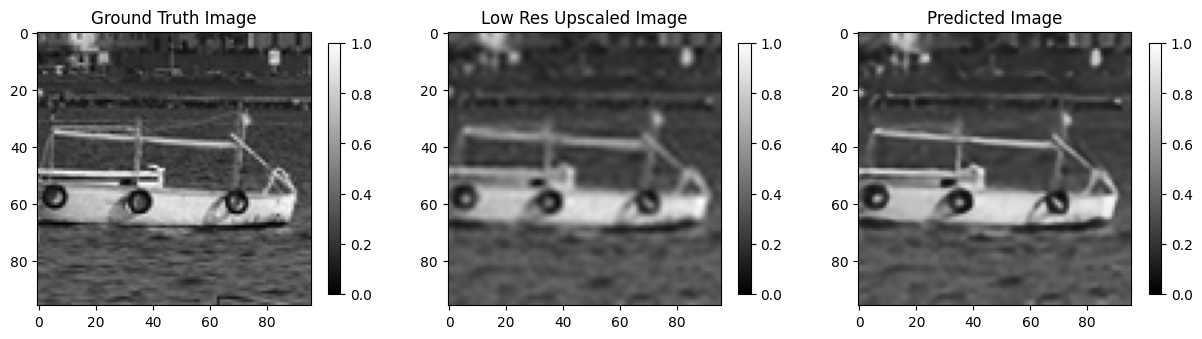

In [18]:
predictedImage = model.predict(X_test[randIndex:randIndex+1])

plt.figure(figsize=(15, 5))

# Plot the ground truth image
plt.subplot(1, 3, 1)
im1 = plt.imshow(Y_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im1, shrink=0.65)
plt.title('Ground Truth Image')

# Plot the low res upscaled image
plt.subplot(1, 3, 2)
im2 = plt.imshow(X_test[randIndex, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im2, shrink=0.65)
plt.title('Low Res Upscaled Image')

# plot the output of image using our model
plt.subplot(1, 3, 3)
im3 = plt.imshow(predictedImage[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar(im3, shrink=0.65)
plt.title('Predicted Image')
